## Keras GAN
A simple GAN for generating digits from MNIST.

Note keras_adverserial seems broken on later versions of Keras (use 2.0.0)

In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from scipy.misc import imread

import keras
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer
from keras.regularizers import L1L2
from keras.utils import np_utils
import matplotlib.pyplot as plt

C:\Applications\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


Load the mnist data and show a few samples

In [2]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


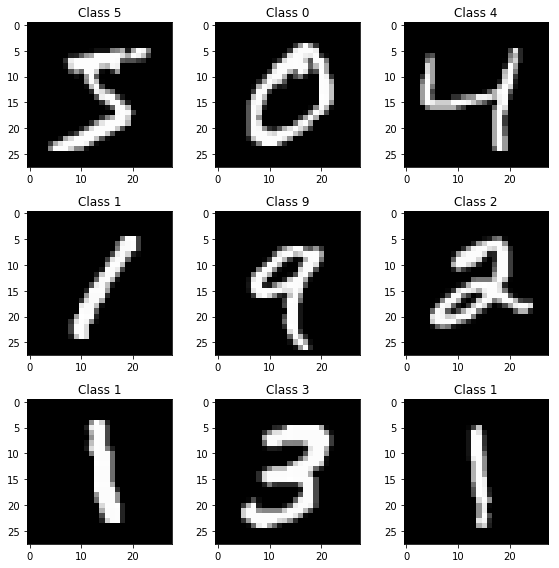

In [4]:
fig=plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title("Class {}".format(y_train[i]))
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
plt.tight_layout()

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [5]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. As this is a multi-class classification problem we need to one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [6]:
# one hot encode outputs and save original classes
print(y_train.shape)
print(y_test.shape)
print(y_train[:10])
y_train_classes = y_train.copy()
y_test_classes = y_test.copy()
y_train = np_utils.to_categorical(y_train_classes)
y_test = np_utils.to_categorical(y_test_classes)
num_classes = y_test.shape[1]
print(y_train.shape)
print(y_test.shape)
print(y_train[:3])

(60000,)
(10000,)
[5 0 4 1 9 2 1 3 1 4]
(60000, 10)
(10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## GAN

The training dataset is structured as a 3-dimensional array of (instance, image width and image height). Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector.

We can do this transform easily using the reshape() function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [7]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train_FF = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test_FF = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
print(X_train_FF.shape)
print(X_test_FF.shape)

(60000, 784)
(10000, 784)


Define our generator and discriminator networks.

In [8]:
# define vars 
g_input_shape = 100 
d_input_shape = (28, 28) 
hidden_1_num_units = 500 
hidden_2_num_units = 500 
g_output_num_units = 784 
d_output_num_units = 1 
epochs = 25 
batch_size = 128

In [9]:
# generator
model_1 = Sequential([
    Dense(units=hidden_1_num_units, input_dim=g_input_shape, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Dense(units=g_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Reshape(d_input_shape),
])

# discriminator
model_2 = Sequential([
    InputLayer(input_shape=d_input_shape),
    Flatten(),
    Dense(units=hidden_1_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Dense(units=d_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
])

# gan
gan = simple_gan(model_1, model_2, normal_latent_sampling((100,)))

# final model
model = AdversarialModel(base_model=gan,player_params=[model_1.trainable_weights, model_2.trainable_weights])
model.adversarial_compile(adversarial_optimizer=AdversarialOptimizerSimultaneous(), player_optimizers=['adam', 'adam'], loss='binary_crossentropy')

AttributeError: 'Model' object has no attribute 'internal_input_shapes'

In [ ]:
print(model_1.summary())

In [ ]:
print(model_2.summary())

In [ ]:
print(gan.summary())

Fit the model

In [ ]:
history = model.fit(x=train_x, y=gan_targets(train_x.shape[0]), epochs=10, batch_size=batch_size)

Plot loss for the model to see if more epochs would have helped and to ensure that we don't start overfitting.

In [ ]:
plt.plot(history.history['player_0_loss'])
plt.plot(history.history['player_1_loss'])
plt.plot(history.history['loss'])

### Generate Images

In [ ]:
zsamples = np.random.normal(size=(10, 100))
pred = model_1.predict(zsamples)
for i in range(pred.shape[0]):
    plt.imshow(pred[i, :], cmap='gray')
    plt.show()